link : 
- PRIVATE - ASK DSF 

Method:

1. Clean data - severity high or very high 
2. Claasify each disturbance typpe into on the 3 categories : 
    - 1 : Biotic-factor
    - 2 : Abiotic-factor
    - 3 : others 

In [2]:
#loading the data

import pandas as pd
df = pd.read_excel('/Users/arthurcalvi/Data/Disturbances_maps/Thierry Belouard & DSF/Veille_sanitaire/veille sanitaire DSF 2007_2023.xlsx', sheet_name='signalement0', header=2)

#convert to geopandas dataframe using lambert 93 coordinates
import geopandas as gpd
from shapely.geometry import Point

df['geometry'] = df.apply(lambda x: Point(x['Longitude'],x['Latitude']),axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs={'init': 'epsg:4326'})

columns = ["Année d'observation", "geometry", "Nom de commune saisie", "LIB_Département", 
           "LIB_Essence regroupée (ess. concernée)", "LIB_Feuillus/Résineux (ess. concernée)", 
            "Pourcentage de tiges atteintes", "Sévérité", 
             "LIB_Problème principal", "LIB_Type de problème", "Remarques"]

gdf = gdf[columns]


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Filtering on severity and causes

Keeping only severe and extremely severe events. 

The causes linked to mammals are not kept. 

In [3]:
gdf_filtered = gdf[gdf['Sévérité'] > 2]

In [4]:
gdf_filtered['LIB_Type de problème'].unique()

array(['Autre symptôme', "Dégât d'origine entomologique", nan,
       'Dégât dû à des végétaux', 'Dégât du à des mammifères',
       "Dégât d'origine abiotique", "Dégât d'origine pathologique",
       'Inconnu ou indéterminé', "Dégât d'origine sylvicole",
       'Dégât du à des grands mammifères', 'Dégât du à une pollution',
       "Dégât dû à d'autres animaux"], dtype=object)

In [5]:
gdf_filtered = gdf_filtered[ gdf_filtered['LIB_Type de problème'].isin(["Dégât d'origine entomologique", \
                                 "Dégât d'origine abiotique", "Dégât dû à des végétaux", \
                                    "Dégât d'origine pathologique", "Dégât d'origine sylvicole", \
                                        "Dégât du à une pollution"]) ]

In [6]:
gdf_filtered.shape

(32276, 11)

# Classification

- Biotic-factors : "Dégât d'origine entomologique", "Dégât d'origine pathologique"
- Abiotic-factors : "Dégât d'origine abiotique", "Dégât d'origine sylvicole", "Dégât du à une pollution"
- Others : "Dégât dû à des végétaux"

In [11]:
def hl_class(x):
    if x in ["Dégât d'origine entomologique", "Dégât d'origine pathologique", "Dégât dû à des végétaux"]:
        return 'biotic-factor'
    elif x in ["Dégât d'origine abiotique", "Dégât d'origine sylvicole", \
                                        "Dégât du à une pollution"]:
        return 'abiotic-factor'
    else:
        return 'other'

In [12]:
gdf_filtered['class'] = gdf_filtered['LIB_Type de problème'].apply(hl_class)

In [9]:
gdf_filtered.columns

Index(['Année d'observation', 'geometry', 'Nom de commune saisie',
       'LIB_Département', 'LIB_Essence regroupée (ess. concernée)',
       'LIB_Feuillus/Résineux (ess. concernée)',
       'Pourcentage de tiges atteintes', 'Sévérité', 'LIB_Problème principal',
       'LIB_Type de problème', 'Remarques', 'class'],
      dtype='object')

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


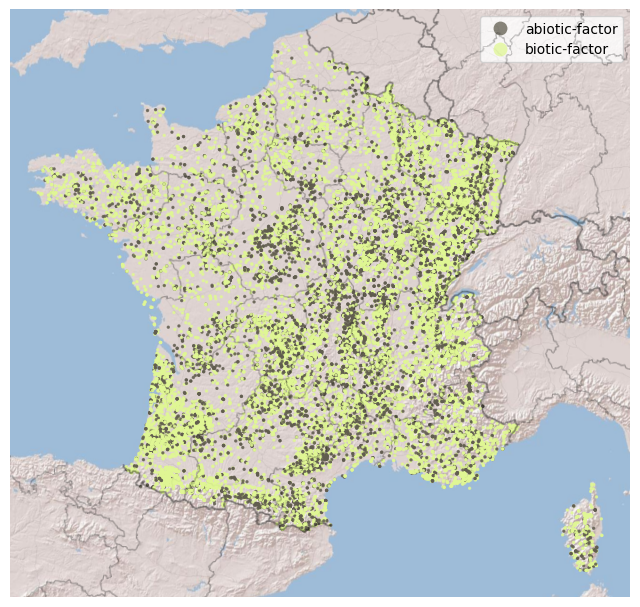

In [16]:
#custom cmap with [yellow, yellowbrown, light brown, red, dark bluegreen, grey]
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

#color black in #
colors = ['#615d4f', '#e0f794']
cmap = ListedColormap(colors)

gplot = gdf_filtered.to_crs({'init': 'epsg:32631'})
import contextily as cx 
ax = gplot.plot(column='class', figsize=(8,8), legend=True, alpha=0.75, markersize=2, cmap=cmap)
ax.set_axis_off()
source = cx.providers.Esri.WorldShadedRelief
cx.add_basemap(ax, crs=gplot.crs, source=source, attribution=False)
#add tonelite map
cx.add_basemap(ax, crs=gplot.crs, zoom=6, source=cx.providers.Stamen.TonerLines, attribution=False, alpha=0.5)


In [17]:
ax.get_figure().savefig('../figures/classification_health-monitoring.png', dpi=200, bbox_inches='tight')

In [21]:
gdf_filtered["Année d'observation"].unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023])

In [26]:
gdf_filtered.dtypes

Année d'observation                          int64
geometry                                  geometry
Nom de commune saisie                       object
LIB_Département                             object
LIB_Essence regroupée (ess. concernée)      object
LIB_Feuillus/Résineux (ess. concernée)      object
Pourcentage de tiges atteintes               int64
Sévérité                                     int64
LIB_Problème principal                      object
LIB_Type de problème                        object
Remarques                                   object
class                                       object
dtype: object

In [3]:
for col in ["Nom de commune saisie", "LIB_Département", "LIB_Essence regroupée (ess. concernée)",\
             "LIB_Feuillus/Résineux (ess. concernée)", "LIB_Problème principal", "LIB_Type de problème", \
                "Remarques", "class"]:
    gdf_filtered[col] = gdf_filtered[col].astype(str)

gdf_filtered.rename(columns={"Année d'observation": "year"},  inplace=True)
gdf_filtered.to_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet')

# Cleaning essence 

In [1]:
import geopandas as gpd

gdf = gpd.read_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet')



In [3]:
gdf['LIB_Essence regroupée (ess. concernée)'].unique()

array(['Épicéas', 'Chênes', 'Sapins', 'Bouleaux', 'Pins', 'Douglas',
       'Charme', 'Autres feuillus', 'Fruitiers', 'Peupliers', 'Hêtre',
       'Mélèzes', 'Frênes', 'Cèdres', 'Tremble', 'Saules', 'Ormes',
       'Châtaignier', 'Érables', 'Arbustes', 'Aulnes', 'Noyers',
       'Autres résineux', 'nan', 'Taxodiacées', 'Tilleuls'], dtype=object)

In [4]:
import numpy as np

# Dictionary to hold translations
translation_dict = {
    'Épicéas': 'Spruces',
    'Chênes': 'Oaks',
    'Sapins': 'Firs',
    'Bouleaux': 'Birches',
    'Pins': 'Pines',
    'Douglas': 'Douglas',
    'Charme': 'Hornbeam',
    'Autres feuillus': 'Other Broadleaves',
    'Fruitiers': 'Fruit Trees',
    'Peupliers': 'Poplars',
    'Hêtre': 'Beech',
    'Mélèzes': 'Larches',
    'Frênes': 'Ash Trees',
    'Cèdres': 'Cedars',
    'Tremble': 'Aspen',
    'Saules': 'Willows',
    'Ormes': 'Elms',
    'Châtaignier': 'Chestnut',
    'Érables': 'Maples',
    'Arbustes': 'Shrubs',
    'Aulnes': 'Alders',
    'Noyers': 'Walnuts',
    'Autres résineux': 'Other Conifers',
    'nan': np.nan,  # Assuming 'nan' is kept as is
    'Taxodiacées': 'Taxodiaceae (a family of coniferous trees)',
    'Tilleuls': 'Lindens'
}


gdf['essence'] = gdf['LIB_Essence regroupée (ess. concernée)'].apply(lambda x: translation_dict[x])

In [6]:
gdf['LIB_Feuillus/Résineux (ess. concernée)'].unique()

def get_tree_type(x):
    if x == 'Conifère':
        return 'conifer'
    elif x == 'Feuillu':
        return 'broadleaf'
    else:
        return np.nan 
    
gdf['tree_type'] = gdf['LIB_Feuillus/Résineux (ess. concernée)'].apply(get_tree_type)

In [9]:
gdf[['year', 'geometry', 'LIB_Problème principal', 'Remarques', 'class', 'essence', 'tree_type']].to_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet')